## Example 1: Cellular Response to Step Current

In [91]:
#===============================================================================================================
# 2020 Hay lab, Krembil Centre for Neuroinformatics, Summer School. Code available for educational purposes only
#===============================================================================================================
#===================================================================
# Import Modules and load relevant files
#===================================================================
import os
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *
from PIL import Image
import matplotlib.image as mpimg

steps = [0,.02,.04,.06,.08,.1,.12,.14,.16,.18,.2] # different IClamp currents
spikerate = []           # store neuron spikerate for each step
current_example = []     # store example current for figure
voltage_example = []     # store example somatic voltage for figure

for step in steps:
    print('Running step',step)
    print('Mechanisms found: ', os.path.isfile('mod/x86_64/special'))

    neuron.h('forall delete_section()')
    neuron.load_mechanisms('mod/')
    h.load_file('net_functions.hoc')
    h.load_file('models/biophys_HL23PN1.hoc')
    h.load_file('models/biophys_HL23MN1.hoc')


    #===================================================================
    # Simulation Controls
    #===================================================================

    celltype = 'HL23PN1'  # or MN1
    step_amp = step

    #===================================================================
    # Parameters
    #===================================================================

    dt = 0.0625
    tstart = 0.
    t_stim = 300. 
    tstop = 1200.
    celsius = 34.
    v_init = -80.

    popargs = {'radius':1,
               'loc':0,
               'scale':1}

    rotations = {'HL23PN1':{'x':1.57,'y':2.62},
                 'HL23MN1':{'x':1.77,'y':2.77},
                 'HL23BN1':{'x':1.26,'y':2.57},
                 'HL23VN1':{'x':-1.57,'y':3.57}}

    networkParams = {
        'dt' : dt,
        'tstart': tstart,
        'tstop' : tstop,
        'v_init' : v_init,
        'celsius' : celsius,
        'verbose' : False,
        'OUTPUTPATH': 'Circuit_output/E1/'}

    morphpath = 'morphologies/' + celltype + '.swc'
    templatepath = 'models/NeuronTemplate.hoc'
    templatename = 'NeuronTemplate'

    cellParams = {
        'morphology': morphpath,
        'templatefile': templatepath,
        'templatename': templatename,
        'templateargs': morphpath,
        'v_init': v_init, 
        'passive': False,
        'dt': dt,
        'tstart': 0.,
        'tstop': tstop,
        'nsegs_method': None,
        'pt3d': False,
        'delete_sections': True,
        'verbose': True}
    if celltype in rotations.keys():
        rotation = rotations.get(celltype)

    popParams = {
        'CWD': None,
        'CELLPATH': None,
        'Cell' : LFPy.NetworkCell,
        'POP_SIZE': 1,
        'name': celltype,
        'cell_args' : {**cellParams},
        'pop_args' : popargs,
        'rotation_args' : rotation}

    #===================================================================
    # Instantiate Network and Cell
    #===================================================================

    network = Network(**networkParams)

    print('\n'+'Initiating '+celltype+' population...')
    network.create_population(**popParams)

    for cellind in range(0,len(network.populations[celltype].cells)):
        biophys = 'h.biophys_' + celltype + '(network.populations[\'' + celltype + '\'].cells[' + str(cellind) + '].template)'
        exec(biophys)

    #===================================================================
    # Add IClamp to Cell
    #===================================================================

    stimParams = {
        'idx' : 0,
        'record_current' : True,
        'pptype' : 'IClamp',
        'amp' : step,
        'dur' : 700,
        'delay' : t_stim}

    for cell in network.populations[celltype].cells:
        cell.stimireclist = neuron.h.List()
        cell.pointprocess_idx.append(0)
        cell.hocidx = int(cell.set_point_process(idx=0, record_current=True,pptype='IClamp',amp=step_amp,dur=700,delay=t_stim))
        for pp in cell.pointprocesses:
            pp.i = np.array(cell.stimireclist.o(cell.hocidx))

    #===================================================================
    # Set Simulation Parameters and Simulate
    #===================================================================

    simargs = {'rec_imem': True,
               'rec_vmem': False,
               'rec_istim':True}

    print('\n'+'Simulating ...')
    SPIKES = network.simulate(**simargs)
    
    spikerate.append(len(SPIKES['times'][0][0])/.7)
    if step==.2:
        a = np.zeros((4800))
        b = np.full((11200),step)
        c = np.zeros((3201))
        ab = np.append(a, b)
        current_example = np.append(ab, c)
        voltage_example = cell.somav
        
   
    ####################################################################
    # Clear space for next iteration
    ####################################################################
    
    network.pc.gid_clear()
    electrode = None
    syn = None
    synapseModel = None
    for population in network.populations.values():
        for cell in population.cells:
            cell = None
            population.cells = None
        population = None
        pop = None
        network = None
        neuron.h('forall delete_section()')

Running step 0
Mechanisms found:  True
Mechanisms already loaded from path: mod/.  Aborting.

Initiating HL23MN1 population...
template NeuronTemplate exist already

Simulating ...
Running step 0.02
Mechanisms found:  True
Mechanisms already loaded from path: mod/.  Aborting.

Initiating HL23MN1 population...
template NeuronTemplate exist already

Simulating ...
Running step 0.04
Mechanisms found:  True
Mechanisms already loaded from path: mod/.  Aborting.

Initiating HL23MN1 population...
template NeuronTemplate exist already

Simulating ...
Running step 0.06
Mechanisms found:  True
Mechanisms already loaded from path: mod/.  Aborting.

Initiating HL23MN1 population...
template NeuronTemplate exist already

Simulating ...
Running step 0.08
Mechanisms found:  True
Mechanisms already loaded from path: mod/.  Aborting.

Initiating HL23MN1 population...
template NeuronTemplate exist already

Simulating ...
Running step 0.1
Mechanisms found:  True
Mechanisms already loaded from path: mod/.

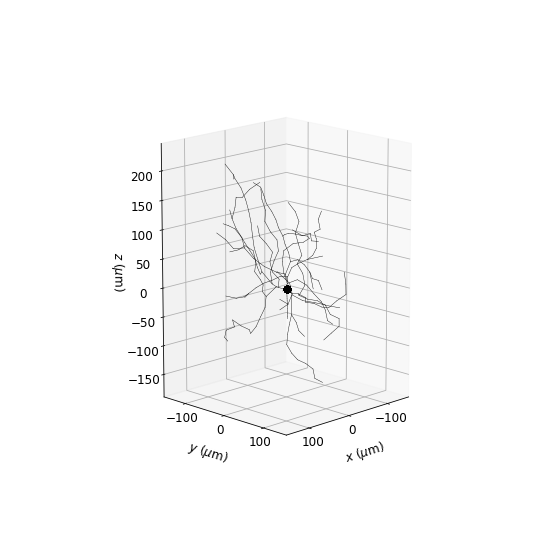

In [87]:
#===================================================================
# Plot Pyramdial Morphology
#===================================================================

fig  = plt.figure(figsize=(10,10))
ax = plt.subplot(111,projection='3d')

x_scale=1
y_scale=1
z_scale=2

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
ax.view_init(elev=15,azim=45)

for i, cell in enumerate(network.populations[celltype].cells):
    for sec in neuron.h.allsec():
        idx = cell.get_idx(sec.name())
        for seg in idx:
            ax.plot(np.r_[cell.x[seg][0], cell.x[seg][1]],
                    np.r_[cell.y[seg][0], cell.y[seg][1]],
                    np.r_[cell.z[seg][0], cell.z[seg][1]], color='k', linewidth=0.4)
            ax.scatter(cell.somapos[0], cell.somapos[1], cell.somapos[2], c='k', marker='.', s=150)
            
ax.set_xticks([100,0,-100])
ax.set_yticks([100,0,-100])
ax.set_xlim([-150,150])
ax.set_ylim([-150,150])
ax.set_xlabel('$x$ ($\mu$m)',labelpad=15,size=12)
ax.set_ylabel('$y$ ($\mu$m)',labelpad=15,size=12)
ax.set_zlabel('$z$ ($\mu$m)',labelpad=30,size=12)
ax.zaxis.set_tick_params(labelsize=12,pad=15)
ax.xaxis.set_tick_params(labelsize=12,pad=0)
ax.yaxis.set_tick_params(labelsize=12,pad=0)

# fig.savefig('SST Morphology.jpg',facecolor='white', edgecolor='none',dpi=650,bbox_inches='tight')

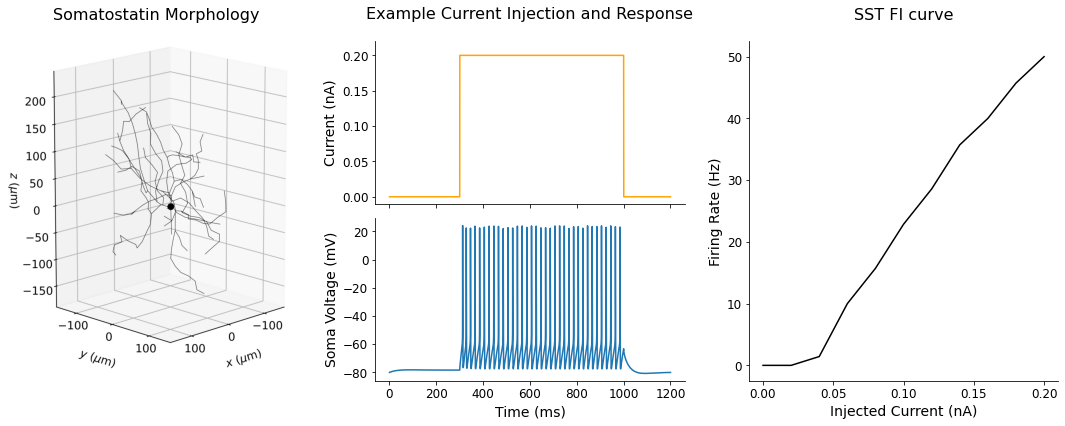

In [95]:
fig  = plt.figure(figsize=(15,6))
lfs,fs,tfs = 12,14,16
morph = plt.subplot2grid((2,3),loc=(0,0),rowspan=2,frameon=False)
morph.imshow(plt.imread('SST Morphology.jpg'))
morph.set_title('Somatostatin Morphology',fontsize=tfs,y=1.045)
morph.set_xticks([])
morph.set_yticks([])
morph.set_ylim(4300,1000)
morph.set_xlim(1000,3900)

tvec = np.arange(0,1200.0625,0.0625)
current = plt.subplot2grid((2,3),loc=(0,1))
current.plot(tvec, current_example, c='orange')
# current.set_ylim([0,1])
current.set_ylabel('Current (nA)',fontsize=fs)
current.set_yticks([0,.05,.1,.15,.2])
current.set_ylim(-.01,.22)
current.set_xticklabels('')
current.set_title('Example Current Injection and Response',fontsize=tfs,y=1.1)

voltage = plt.subplot2grid((2,3),loc=(1,1))
voltage.plot(tvec, voltage_example)
voltage.set_xlabel('Time (ms)',fontsize=fs)
voltage.set_ylabel('Soma Voltage (mV)',fontsize=fs)


FI = plt.subplot2grid((2,3),loc=(0,2),rowspan=2)
FI.plot(steps,spikerate,color='k')
FI.set_xlabel('Injected Current (nA)',fontsize=fs)
FI.set_ylabel('Firing Rate (Hz)',fontsize=fs)
FI.set_xticks([0,.05,.10,.15,.2])
FI.set_title('SST FI curve',fontsize=tfs,y=1.045)

axes = [current,voltage,FI]

[ax.spines[label].set_visible(False) for label in ['right','top'] for ax in axes]
[ax.tick_params(axis='both', which='major', labelsize=lfs) for ax in axes]

plt.tight_layout()

# fig.savefig('SST FI.jpg',facecolor='white', edgecolor='none',dpi=650,bbox_inches='tight')